author: Samuel Begg

date: 06/04/2024

Compute Fisher information for a periodically driven XY model, as discussed in Mishra, Bayat, Phys. Rev. Lett. 127, 080504 (2021)

1. Define simulation parameters

In [1]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Projects/Sensing/'

# System parameters for periodic boundary condition spin chain.
J = 1.0
gamma = 0.1
h1 = 0 # The periodic field is set to zero when considering the ground-state
sites = 6
boundary_conditions = 'ABC' #'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions

# Notes: 
# The boundary conditions reflects the fermion parity of the ground-state.
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

#Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Sensing parameters
phasepoints = 51 # points to sampling h0
h0mat = np.linspace(-2.0,2.0,phasepoints)  # range of points to sample
sub_system_range = np.arange(4,int(4)+1) # range of subsystem sizes for evaluating Fisher information
sub_system_edge = 0 #index of the first site in the sub-system, 0 is the left boundary site.

# Computational 
tol = 10**(-8) # when evaluating the Fisher information we don't consider singular terms for which |1 - (w[rr]*w[ss])| < tol 
shift = 10**(-6) # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
derivative_estimator = 'order2' # 2nd order = 'order2' or 4th order 'order4' approximation for the derivative of reduced density matrix
num_cores = 16  # number of cores to parallelize with
save_results = 'bin' # 'save' or 'bin' (don't save)



2. Calculate Fisher information for ground state

In [2]:
Fishermat = np.zeros([np.size(sub_system_range),np.size(h0mat)])

#Calculate fisher information for different subsystem sizes and h0 values
output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gamma, h0mat[uu], h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for uu in range(0,np.size(h0mat)))

Fisher_mat = []

particle_numberL = []

for kk in range(0,phasepoints):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberL = particle_numberL + [data[1]]

Fishermat= np.asarray(Fisher_mat)

particle_number = np.asarray(particle_numberL)


h0 -1.44
0:00:00.000424 Time to calculate the initial correlation matrices
0:00:00.000078 Time to evaluate Gamma matrix for single h0
0:00:00.000356 Time to calculate the initial correlation matrices
0:00:00.000064 Time to evaluate Gamma matrix for single h0
sub systemh0h0 -1.6
h0 -2.0
0:00:00.000426 Time to calculate the initial correlation matrices
0:00:00.000078 Time to evaluate Gamma matrix for single h0
0:00:00.000418 Time to calculate the initial correlation matrices
0:00:00.000076 0:00:00.000358 Time to calculate the initial correlation matrices
0:00:00.000144 Time to evaluate Gamma matrix for single h0
sub system 4 reduced density eigenvalues h0 -1.3599999999999999
[ 9.99142519e-01  7.32783877e-04  1.24605925e-04  9.13875763e-08
  5.54635515e-16  4.06776766e-19  6.91701837e-20  5.07302957e-23
 -3.94253596e-38 -5.37560314e-35 -3.16129052e-34 -4.31038383e-31
 -7.10224140e-23 -9.68382572e-20 -5.69487473e-19 -7.76489720e-16]
sum eig reduced density 1.0
[-1.         -1.         -0.9

3. Calculate ground state Fisher information for different gamma values

In [3]:
#Want to see scaling for some different gamma values too
gmat = [0.1,0.5,1]

output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gmat[gg], 1.0, h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for gg in range(0,np.size(gmat)))

Fisher_mat = []

particle_numberG = []

for kk in range(0,np.size(gmat)):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberG = particle_numberG + [data[1]]

FishermatGamma= np.asarray(Fisher_mat)

particle_numberG = np.asarray(particle_numberG)


h0 1.0
0:00:00.000439 Time to calculate the initial correlation matrices
0:00:00.000086 Time to evaluate Gamma matrix for single h0
0:00:00.000380 Time to calculate the initial correlation matrices
0:00:00.000072 Time to evaluate Gamma matrix for single h0
sub system 4 reduced density eigenvalues [ 9.81881595e-01  1.81178710e-02  5.24507271e-07  9.67831062e-09
  1.09010755e-15  2.01148775e-17  5.82320048e-22  1.07450833e-23
 -1.78941583e-38 -9.69757688e-37 -3.34980003e-32 -1.81539376e-30
 -1.61176249e-23 -8.73480072e-22 -3.01723163e-17 -1.63516133e-15]
sum eig reduced density 1.0000000000000002
[-1.         -1.         -0.99999893 -0.96376424  0.96376424  0.99999893
  1.          1.        ]
h0 1.0
0:00:00.000648 End Fisher Calculation Number of avoided divergences [8.]
h0 1.0
0:00:00.000505 Time to calculate the initial correlation matrices
0:00:00.000094 Time to evaluate Gamma matrix for single h0
0:00:00.000431 Time to calculate the initial correlation matrices
0:00:00.000075 Time t

Plot Fisher information for groundstates

In [4]:
if save_results == 'save':
    
    np.save('ResultsGS/gmat.npy',gmat)
    np.save('ResultsGS/Fisher_mat_Gamma.npy',FishermatGamma)
    np.save('ResultsGS/h0mat.npy',h0mat)
    #np.save('Fisher_mat.npy',Fishermat)
    np.save('ResultsGS/subsystem.npy',sub_system_range)

import matplotlib.pyplot as plt
plot_system_size_scaling = 'no'

if plot_system_size_scaling == 'yes':



    # for ss in range(1,np.size(sub_system_range),2):

    #     plt.plot(h0mat,Fishermat[:,ss],'--o',label = 'L=' + str(sub_system_range[ss]))

    # plt.ylabel(r'$F_{gs}$')
    # plt.xlabel(r'$h_0$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    # x = np.linspace(0.25,1.5,1000)
    # plt.plot(x,2*x-1,'--r',label = r'$F \sim L^{2}$')
    # plt.plot(x,x-1,'-r',label = r'$F \sim L$')
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[int(np.size(h0mat)/2),:]),label = r'$h_0=$' + str(np.round(h0mat[int(np.size(h0mat)/2)],3)))
    # #plt.plot(np.log10(sub_system_range),np.log10(Fishermat[35,:]),label = r'$h_0=$' + str(np.round(h0mat[35],3)))
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[7,:]),label = r'$h_0=$' + str(np.round(h0mat[0],3)))
    # plt.xlabel(r'$L$')
    # plt.ylabel(r'$F_{gs}$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    x = np.linspace(0.1,2.5,1000)
    plt.plot(x,2*x+2,'--r',label = r'$F \sim L^{2}$')
    plt.plot(x,x+2,'-r',label = r'$F \sim L$')



    ranges = np.arange(1,np.size(sub_system_range))

    a0_0, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[0,ranges]),1)
    plt.plot(x,a0_0*x+a1,'--k')

    print(a0_0)
    a0_1, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[1,ranges]),1)
    plt.plot(x,a0_1*x+a1,'--k')
    print(a0_1)
    a0_2, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[2,ranges]),1)
    plt.plot(x,a0_2*x+a1,'--k')
    print(a0_2)


    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[0,:]),label = r'$\gamma=$' + str(np.round(gmat[0],3))+ r', $\eta = $' + str(np.round(np.real(a0_0),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[1,:]),label = r'$\gamma=$' + str(np.round(gmat[1],3))+ r', $\eta = $' + str(np.round(np.real(a0_1),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[2,:]),label = r'$\gamma=$' + str(np.round(gmat[2],3))+ r', $\eta = $' + str(np.round(np.real(a0_2),3)))
    plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $h_0=1$')
    plt.xlabel(r'$\log_{10} L$')
    plt.ylabel(r'$\log_{10} F_{gs}$')
    plt.legend()
    plt.show()


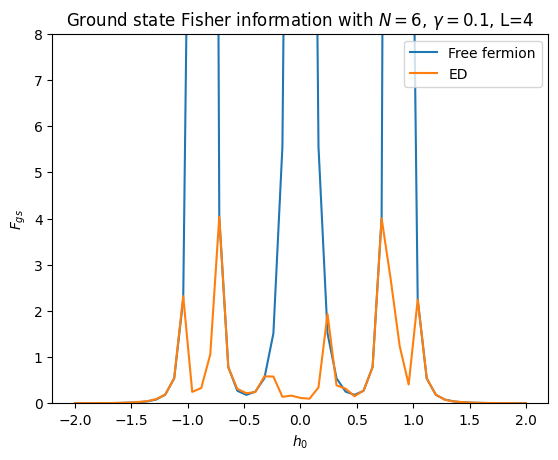

[1.91539136e-03-1.05484662e-19j 2.48111706e-03+3.08347959e-22j
 3.28849683e-03-2.38341627e-23j 4.47893842e-03-6.99466573e-24j
 6.30325531e-03-4.03134194e-19j 9.23136314e-03+1.99663469e-19j
 1.42033985e-02+7.99304248e-22j 2.32572324e-02-3.91597870e-22j
 4.12765423e-02-1.21844751e-19j 8.15858648e-02-1.00632721e-18j
 1.87491253e-01+3.15891366e-19j 5.39794878e-01-3.16334539e-18j
 2.25364249e+00-3.67022472e-18j 1.88638439e+01+1.13377681e-17j
 3.31588256e+02+5.18972175e-17j 4.96214780e+01-2.45517857e-18j
 4.01683557e+00+1.60689581e-18j 7.84963009e-01+8.45257420e-20j
 2.71452953e-01-1.52939936e-19j 1.82802859e-01-1.09526547e-18j
 2.53115093e-01+2.15972745e-18j 5.42700269e-01+6.11523776e-18j
 1.51474841e+00+1.79020418e-18j 5.55543975e+00-4.25206525e-17j
 2.64891392e+01+2.55823697e-16j 7.15786231e+01-1.92034955e-16j
 2.64886292e+01-5.01356852e-17j 5.55534000e+00+8.27158457e-18j
 1.51472673e+00+1.00509640e-17j 5.42694173e-01+8.60560668e-19j
 2.53113221e-01+1.42099050e-18j 1.82802869e-01+3.589781

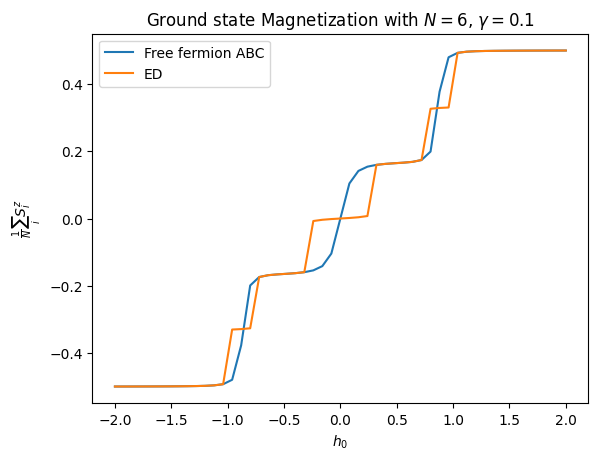

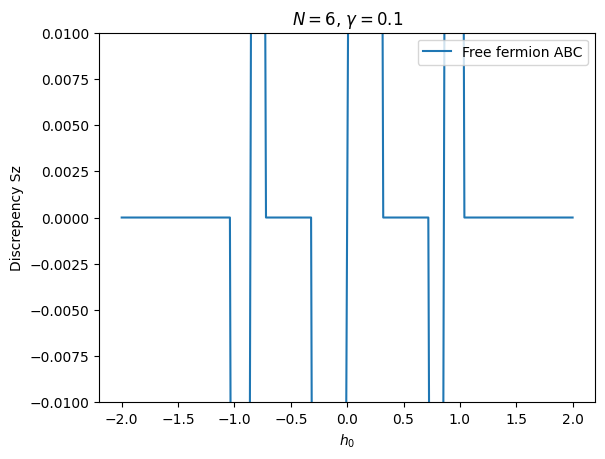

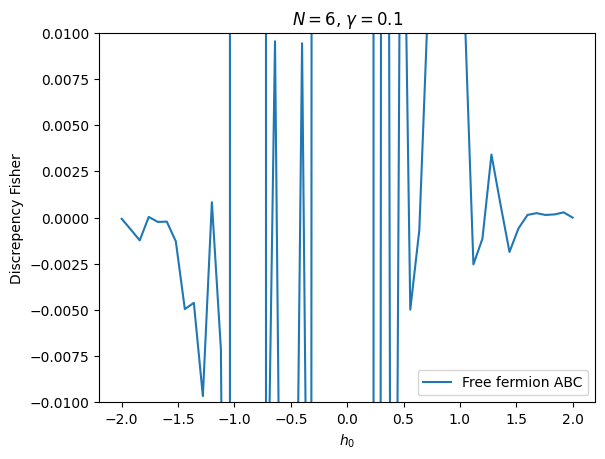

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]
[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


In [6]:
#Comparison vs ED

ss = 0
plt.plot(h0mat,Fishermat[:,ss],label = 'Free fermion')

#Fisher vs h
ED_fisher = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/Fisher.npy')
hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
plt.plot(hzmat,ED_fisher,'-',label='ED')
plt.ylabel(r'$F_{gs}$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma) + ', L=' + str(sub_system_range[ss]))
plt.legend()
plt.ylim(0,8)
plt.show()

print(Fishermat[:,ss], 'Free ferm')
print(ED_fisher, 'ED_Fisher')

#Sz vs h
ED_spin = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/mag.npy')
hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
plt.plot(h0mat,particle_number-0.5,label = 'Free fermion ' + boundary_conditions)
plt.plot(hzmat,ED_spin ,'-',label='ED')
plt.ylabel(r'$\frac{1}{N}\sum_i S^z_i$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Magnetization with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.show()

#Discrepancy Sz vs Exact Diagonalization
plt.plot(h0mat,particle_number-0.5 - ED_spin,label = 'Free fermion ' + boundary_conditions)
plt.ylabel(r'Discrepency Sz')
plt.xlabel(r'$h_0$')
plt.title('$N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.ylim(-0.01,0.01)
plt.show()

#Discrepancy Fisher vs Exact Diagonalization
plt.plot(h0mat,Fishermat[:,ss] - ED_fisher,label = 'Free fermion ' + boundary_conditions)
plt.ylabel(r'Discrepency Fisher')
plt.xlabel(r'$h_0$')
plt.title('$N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.ylim(-0.01,0.01)
plt.show()


print(hzmat)
print(h0mat)